El modelo de Holt-Winters incorpora tres componentes principales para realizar pronósticos: la tendencia, la estacionalidad y el componente de nivel. La tendencia se refiere a la dirección general en la que se mueven los datos a lo largo del tiempo, ya sea en aumento o en disminución. La estacionalidad representa patrones regulares y repetitivos que ocurren en la serie de tiempo, como las ventas estacionales en un negocio. El componente de nivel es el valor medio en la serie de tiempo.

El modelo de Holt-Winters utiliza tres ecuaciones de actualización para estimar y pronosticar estos componentes a medida que avanza en el tiempo. Estas ecuaciones se conocen como ecuaciones de suavización y se utilizan para ajustar los datos observados y calcular las estimaciones de los componentes.

In [2]:
import pandas as pd
import numpy as np

## Daily Bike Sharing - Daily prediction

In [31]:
data = pd.read_csv("/content/Daily Bike Sharing.csv",index_col = "dteday", 
                   parse_dates = True)
data.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [32]:
data = data.loc[:, ["cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
data.head(2)    

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539


In [40]:
data = data.asfreq("D")


In [41]:
data = data.rename(columns = {'cnt' : 'y'})


In [42]:
data.describe()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,4504.348837,0.028728,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486
std,1937.211452,0.167155,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498
min,22.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392
25%,3152.000000,0.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950
50%,4548.000000,0.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975
75%,5956.000000,0.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214
max,8714.000000,1.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463


### Exploratory Data Analysis

In [43]:
data.tail()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-12-27,2114,0,1,2,0.254167,0.226642,0.652917,0.350133
2012-12-28,3095,0,1,2,0.253333,0.255046,0.590000,0.155471
2012-12-29,1341,0,0,2,0.253333,0.242400,0.752917,0.124383
2012-12-30,1796,0,0,1,0.255833,0.231700,0.483333,0.350754
2012-12-31,2729,0,1,2,0.215833,0.223487,0.577500,0.154846


<Axes: xlabel='dteday'>

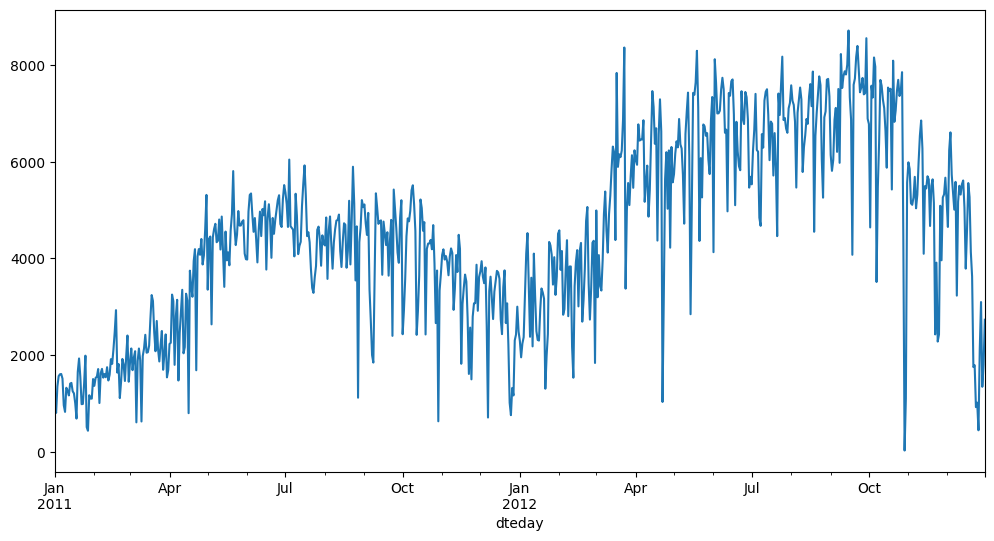

In [44]:
#Visualization

data["y"].plot(figsize = (12,6))

### Data Preparation

In [45]:
test_days = 31

In [48]:
train_set = data.iloc[:-test_days, :]
test_set = data.iloc[-test_days:, :]

In [47]:
train_set.tail()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-11-26,5087,0,1,1,0.313333,0.339004,0.535417,0.046650
2012-11-27,3959,0,1,2,0.291667,0.281558,0.786667,0.237562
2012-11-28,5260,0,1,1,0.296667,0.289762,0.506250,0.210821
2012-11-29,5323,0,1,1,0.280870,0.298422,0.555652,0.115522
2012-11-30,5668,0,1,1,0.298333,0.323867,0.649583,0.058471


### Exponential Smoothing / AI Model

In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [56]:
model = ExponentialSmoothing(endog = train_set.y,   #endogen
                             trend = 'mul',    #multiplicative
                             seasonal = 'mul',       #multiplicative
                             seasonal_periods = 7).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Tendencia aditiva: En este tipo de tendencia, los cambios en la serie de tiempo se suman o restan de forma constante a lo largo del tiempo. Por ejemplo, si hay un aumento lineal constante en los valores de la serie de tiempo, se considera una tendencia aditiva.

Tendencia multiplicativa: En este tipo de tendencia, los cambios en la serie de tiempo se multiplican por un factor constante a medida que transcurre el tiempo. Por ejemplo, si los valores de la serie de tiempo aumentan o disminuyen a una tasa porcentual constante en cada período, se considera una tendencia multiplicativa. En este caso, la serie de tiempo se puede expresar como el nivel medio multiplicado por una componente de tendencia multiplicativa.

In [59]:
predictions_hw = model.forecast(steps = len(test_set)).rename("HW")
predictions_hw.tail(31)

2012-12-01    4676.804684
2012-12-02    4153.246795
2012-12-03    4322.003783
2012-12-04    4279.673415
2012-12-05    4825.991667
2012-12-06    4701.723841
2012-12-07    4674.474174
2012-12-08    4575.268886
2012-12-09    4063.077704
2012-12-10    4228.170892
2012-12-11    4186.759538
2012-12-12    4721.216944
2012-12-13    4599.647035
2012-12-14    4572.988973
2012-12-15    4475.937481
2012-12-16    3974.866229
2012-12-17    4136.375160
2012-12-18    4095.862867
2012-12-19    4618.716933
2012-12-20    4499.786368
2012-12-21    4473.707066
2012-12-22    4378.762612
2012-12-23    3888.569870
2012-12-24    4046.572361
2012-12-25    4006.939610
2012-12-26    4518.442249
2012-12-27    4402.093727
2012-12-28    4376.580620
2012-12-29    4283.697458
2012-12-30    3804.147049
2012-12-31    3958.719225
Freq: D, Name: HW, dtype: float64

<Axes: >

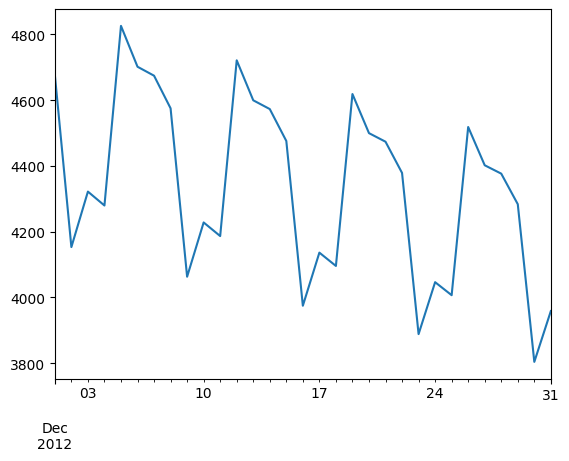

In [57]:
predictions_hw.plot()

<Axes: xlabel='dteday'>

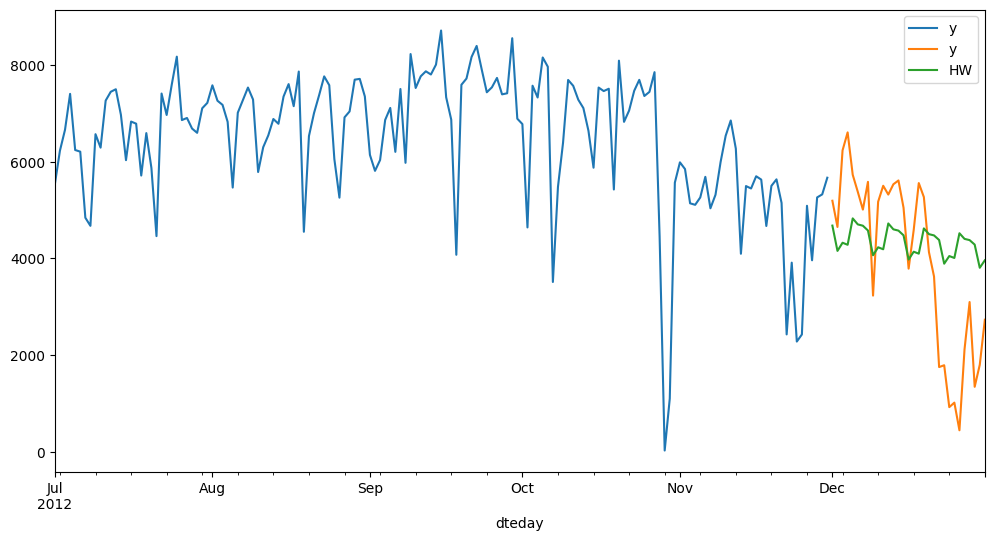

In [61]:
train_set['y']['2012-07-01':].plot(figsize = (12,6), legend = True)
test_set['y'].plot(legend = True)
predictions_hw.plot(legend = True)

#### Metrics

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_hw),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_hw)), 0))

1389.0
1698.0


In [63]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_hw)


87.26099293841784

## Airmiles - Monthly prediction

In [65]:
data = pd.read_csv("airmiles.csv", index_col = "Date")
data.head()

,airmiles
Date,
1/1/1996,30983174
1/2/1996,32147663
1/3/1996,38342975
1/4/1996,35969113
1/5/1996,36474391


In [66]:
data.index = pd.to_datetime(data.index,
                            format = "%d/%m/%Y")


In [67]:
data = data.asfreq("MS")


<Axes: xlabel='Date'>

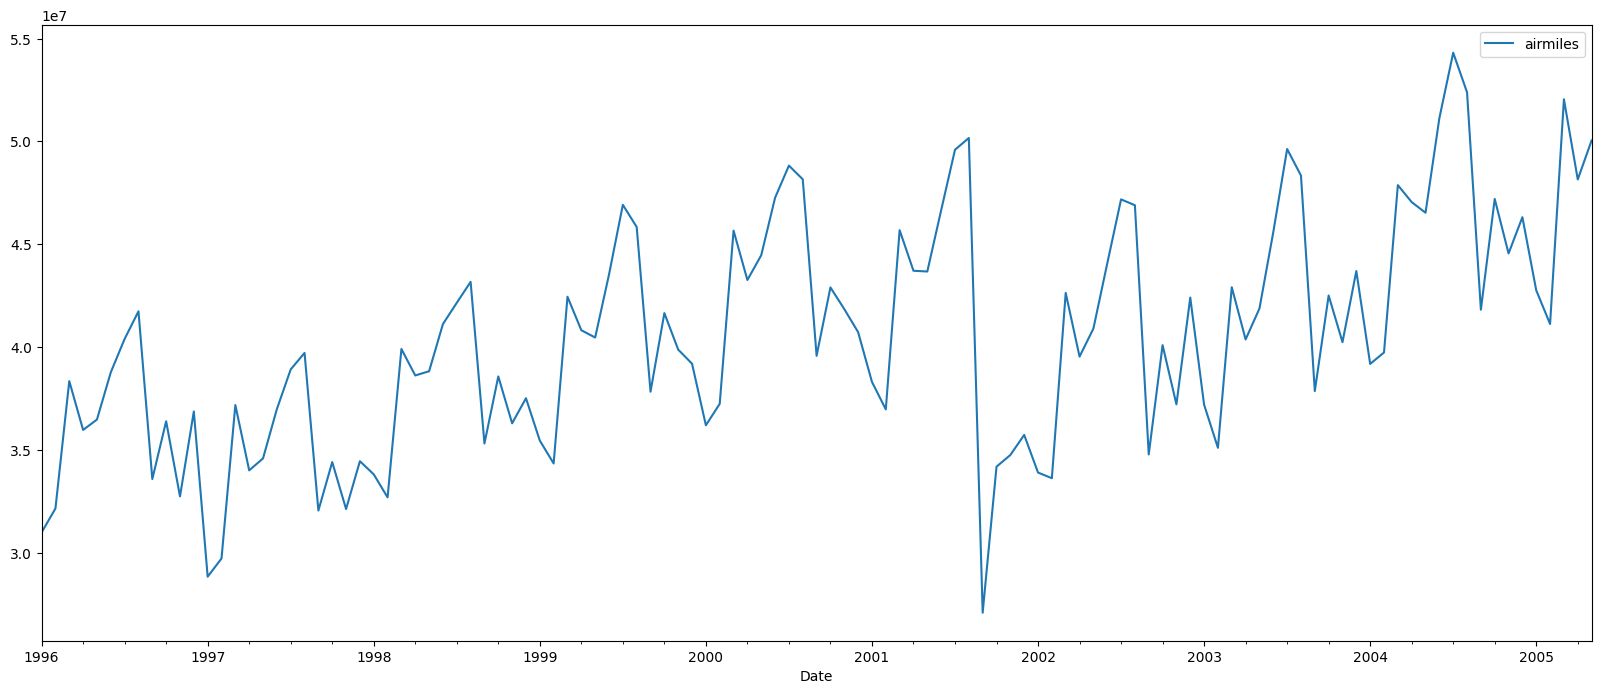

In [68]:

data.plot(figsize = (20,8))

In [69]:
test_months = 12
training_set = data.iloc[:-test_months,:]
test_set = data.iloc[-test_months:,:]


In [70]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(training_set['airmiles'],
                             trend = 'add',
                             seasonal = 'mul',
                             seasonal_periods = 12).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [71]:
predictions = model.forecast(steps = 12).rename("HW")
predictions

2004-06-01    4.985031e+07
2004-07-01    5.224279e+07
2004-08-01    5.236168e+07
2004-09-01    4.136596e+07
2004-10-01    4.618046e+07
2004-11-01    4.350886e+07
2004-12-01    4.564370e+07
2005-01-01    4.123315e+07
2005-02-01    4.082851e+07
2005-03-01    5.023941e+07
2005-04-01    4.767275e+07
2005-05-01    4.818133e+07
Freq: MS, Name: HW, dtype: float64

<Axes: xlabel='Date'>

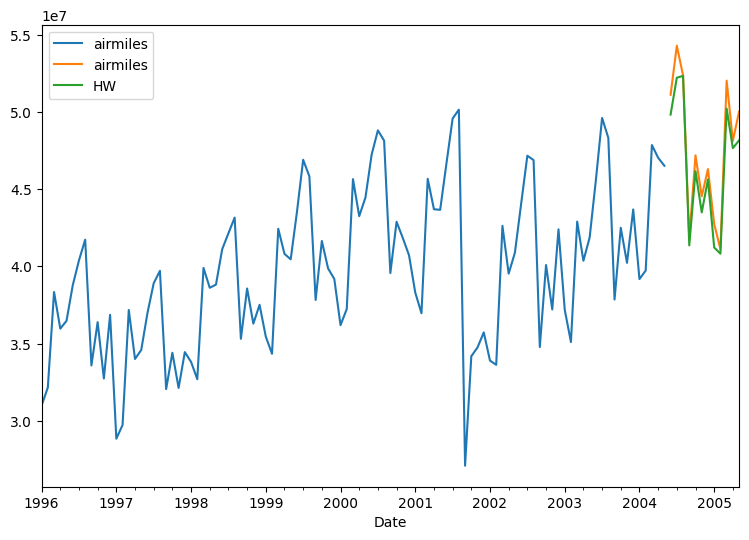

In [72]:
training_set['airmiles'].plot(figsize = (9,6), legend = True)
test_set['airmiles'].plot(legend = True)
predictions.plot(legend = True)

In [73]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_set['airmiles'], predictions)

1046933.5311963571

In [76]:
print(round(np.sqrt(mean_squared_error(test_set['airmiles'], predictions)), 0))

1230641.0
